# Exoplanet Habitability Analysis Pipeline

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import shap

/opt/anaconda3/envs/data512/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if Path.cwd().name == "notebooks":
    project_root = Path.cwd().parent
    sys.path.insert(0, str(project_root))
else:
    project_root = Path.cwd()
    sys.path.insert(0, str(project_root))

# Data directories (relative paths)
data_raw = project_root / "data" / "raw"
data_processed = project_root / "data" / "processed"
reports_dir = project_root / "reports"

# Create directories if needed
data_raw.mkdir(parents=True, exist_ok=True)
data_processed.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

In [3]:
from src.build_features import add_derived_columns, DERIVED_COLUMNS
from src.impute_dataset import impute
from src.feature_selection import compute_feature_importance, compute_extended_esi as compute_extended_esi_rf, ESI_FEATURES
from src.esi import compute_esi, compute_esi_radius_mass_only, compute_extended_esi

In [4]:
# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [5]:
raw_path = data_raw / "exoplanets_pscomppars.csv"
processed_path = data_processed / "processed_exoplanets.csv"
imputed_path = data_processed / "processed_exoplanets_imputed.csv"

## Phase 1

### Data Ingestion

**Note:** Before running this notebook, please run `notebooks/data_ingestion.ipynb` first to download and save the raw data files.

In [6]:
if not raw_path.exists():
    raise FileNotFoundError(
        f"Raw data not found at {raw_path}. "
        f"Please run notebooks/data_ingestion.ipynb first to download and save the data."
    )

df_raw = pd.read_csv(raw_path)
print(f"Loaded raw data. Shape: {df_raw.shape}")

earth_in_raw = df_raw["pl_name"].str.lower() == "earth"
if not earth_in_raw.any():
    print("Warning: Earth not found in raw data. Data may need to be re-downloaded.")

df_raw.head()

Loaded raw data. Shape: (6060, 683)


,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,cb_flag,pl_angsep,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepformat,pl_angsepstr,pl_angsepsymerr,pl_angsep_reflink,pl_ndispec
0,3.2390,Kepler-1167 b,b,2.136990,Kepler-1167,NaN,NaN,TIC 273875149,2016-05,2016.0,...,0.0,0.0213,NaN,NaN,0.0,NaN,0.0213,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0
1,3.1444,Kepler-1740 b,b,2.433343,Kepler-1740,NaN,NaN,TIC 138479461,2022-02,2021.0,...,0.0,0.0734,NaN,NaN,0.0,NaN,0.0734,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0
2,3.4135,Kepler-1581 b,b,2.442550,Kepler-1581,NaN,NaN,TIC 121215710,2016-05,2016.0,...,0.0,0.1390,NaN,NaN,0.0,NaN,0.1390,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0
3,3.6590,Kepler-644 b,b,2.512738,Kepler-644,NaN,NaN,TIC 271669616,2016-05,2016.0,...,0.0,0.0352,NaN,NaN,0.0,NaN,0.0352,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0
4,3.1575,Kepler-1752 b,b,2.507010,Kepler-1752,NaN,NaN,TIC 417655835,2022-02,2021.0,...,0.0,0.2800,NaN,NaN,0.0,NaN,0.2800,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0


### Build Derived Features

Compute research-backed derived features:
- Surface gravity & escape velocity (Schulze-Makuch et al., 2011)
- Bulk density (Seager et al., 2007)
- Habitable zone bounds (Kasting et al., 1993)
- Eccentricity habitability score (Rodríguez-Mozos & Moya, 2025)

In [7]:
if processed_path.exists():
    df_processed = pd.read_csv(processed_path)
    print(f"Loaded processed data. Shape: {df_processed.shape}")
else:
    print("Building derived features...")
    df_processed = add_derived_columns(df_raw.copy())
    df_processed.to_csv(processed_path, index=False)
    print(f"Saved processed dataset: {df_processed.shape}")

print(f"\nDerived features created: {[c for c in DERIVED_COLUMNS if c in df_processed.columns]}")
df_processed.head()

Loaded processed data. Shape: (6060, 691)

Derived features created: ['pl_surfgrav_m_s2', 'pl_escvel_km_s', 'pl_dens_calc', 'st_luminosity_solar', 'hz_inner_au', 'hz_outer_au', 'in_habitable_zone']


,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,pl_angsep_reflink,pl_ndispec,pl_surfgrav_m_s2,pl_escvel_km_s,pl_dens_calc,st_luminosity_solar,hz_inner_au,hz_outer_au,in_habitable_zone,ecc_hab_score
0,3.2390,Kepler-1167 b,b,2.136990,Kepler-1167,NaN,NaN,TIC 273875149,2016-05,2016.0,...,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0,NaN,NaN,NaN,0.308168,0.529294,0.762528,0,1.0
1,3.1444,Kepler-1740 b,b,2.433343,Kepler-1740,NaN,NaN,TIC 138479461,2022-02,2021.0,...,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0,NaN,NaN,NaN,0.778412,0.841218,1.211900,0,1.0
2,3.4135,Kepler-1581 b,b,2.442550,Kepler-1581,NaN,NaN,TIC 121215710,2016-05,2016.0,...,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0,NaN,NaN,NaN,1.785102,1.273900,1.835243,0,1.0
3,3.6590,Kepler-644 b,b,2.512738,Kepler-644,NaN,NaN,TIC 271669616,2016-05,2016.0,...,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0,NaN,NaN,NaN,6.091017,2.353144,3.390057,0,1.0
4,3.1575,Kepler-1752 b,b,2.507010,Kepler-1752,NaN,NaN,TIC 417655835,2022-02,2021.0,...,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0.0,NaN,NaN,NaN,0.531969,0.695420,1.001856,0,1.0


### Impute Missing Values

Apply two-stage imputation:
1. **Deterministic reconstruction**: Mass-radius relations (Chen & Kipping, 2017)
2. **Iterative imputation**: MICE with predictive mean matching (van Buuren, 2018)
   - Excludes Earth/Solar System rows from model fitting
   - Tracks imputation flags for uncertainty propagation

Then **calculate ESI** after imputation to ensure all planets have complete data for ESI computation.

*Note: Row filtering happens later during feature selection based on required core features.*

In [8]:
if imputed_path.exists():
    df_imputed = pd.read_csv(imputed_path)
    print(f"Loaded imputed data. Shape: {df_imputed.shape}")
else:
    print(f"Applying imputation on df with shape {df_processed.shape} (this may take some time)...")
    df_imputed = impute(df_processed)
    df_imputed.to_csv(imputed_path, index=False)
    print(f"Imputed dataset saved: {df_imputed.shape}")

imputation_flags = [c for c in df_imputed.columns if "_flag" in c or "_imputed_flag" in c]
print(f"\nImputation flags: {imputation_flags[:5]}... ({len(imputation_flags)} total)")
if imputation_flags:
    for flag in imputation_flags[:5]:
        imputed_count = int(df_imputed[flag].sum())
        print(f"\t{flag}: {imputed_count}/{len(df_imputed)} values imputed")

Loaded imputed data. Shape: (6060, 704)

Imputation flags: ['pl_controv_flag', 'dkin_flag', 'ttv_flag', 'ptv_flag', 'tran_flag']... (26 total)
	pl_controv_flag: 40/6060 values imputed
	dkin_flag: 1/6060 values imputed
	ttv_flag: 478/6060 values imputed
	ptv_flag: 2/6060 values imputed
	tran_flag: 4504/6060 values imputed


In [9]:
# Calculate ESI after imputation (on complete data)
print("\nCalculating ESI on imputed data...")
df_imputed["esi"] = compute_esi(df_imputed)
df_imputed["esi_radius_mass"] = compute_esi_radius_mass_only(df_imputed)

print(f"ESI statistics: mean={df_imputed['esi'].mean():.4f}, median={df_imputed['esi'].median():.4f}")
df_imputed.head()


Calculating ESI on imputed data...
ESI statistics: mean=0.3032, median=0.3082


,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,pl_orbper_mice_flag,pl_dens_mice_flag,st_teff_mice_flag,st_met_mice_flag,st_mass_mice_flag,st_rad_mice_flag,pl_surfgrav_m_s2_mice_flag,pl_escvel_km_s_mice_flag,esi,esi_radius_mass
0,3.2390,Kepler-1167 b,b,2.136990,Kepler-1167,NaN,NaN,TIC 273875149,2016-05,2016.0,...,0,0,0,0,0,0,1,1,0.000000,0.394898
1,3.1444,Kepler-1740 b,b,2.433343,Kepler-1740,NaN,NaN,TIC 138479461,2022-02,2021.0,...,0,0,0,0,0,0,1,1,0.294312,0.226551
2,3.4135,Kepler-1581 b,b,2.442550,Kepler-1581,NaN,NaN,TIC 121215710,2016-05,2016.0,...,0,0,0,0,0,0,1,1,0.000000,0.587326
3,3.6590,Kepler-644 b,b,2.512738,Kepler-644,NaN,NaN,TIC 271669616,2016-05,2016.0,...,0,0,0,0,0,0,1,1,0.000000,0.200661
4,3.1575,Kepler-1752 b,b,2.507010,Kepler-1752,NaN,NaN,TIC 417655835,2022-02,2021.0,...,0,0,0,0,0,0,1,1,0.280907,0.202688


## Phase 2: What ESI Misses

### Feature Importance via Random Forest + SHAP (Excluding ESI Features)

**Key Innovation**: ESI is defined by 5 physical parameters (radius, mass, density, escape velocity, temperature). However, habitability depends on many other factors!.

We train a Random Forest to predict ESI using **ONLY non-ESI features** (orbital characteristics, stellar properties, derived metrics). This reveals:
1. What factors beyond ESI's definition predict Earth-like conditions
2. Whether the ESI metric is incomplete
3. Which orbital/stellar features matter for habitability

**If R^2 is high (>0.7)**, it proves ESI is incomplete - other features strongly predict habitability

In [ ]:
print("Computing feature importance using ESI as target...")

results = compute_feature_importance(
    df_imputed.copy(), 
    output_dir=reports_dir,
    correlation_threshold=0.90,
    min_features_required=0.5,
)

importance_df = results.importance_df
feature_matrix = results.feature_matrix
X = results.X
model = results.model
shap_values = results.shap_values
df_filtered = results.df_filtered

# Use filtered dataframe for all subsequent analysis
df_imputed = df_filtered.copy()
print(f"\nFiltered dataset: {len(df_imputed):,} planets")

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Standardized features shape: {X.shape}")

earth_mask = df_imputed["pl_name"].str.lower() == "earth"
if not earth_mask.any():
    raise ValueError("Earth not found in dataset!")

Computing feature importance using ESI as target...
Filtered to 6051 planets with required core features: ['pl_rade', 'pl_masse']

Found 3 highly correlated feature pairs (>=0.9):
	pl_orbeccen <-> ecc_hab_score: 0.986
	pl_insol <-> pl_orbper: 0.962
	pl_orbsmax <-> pl_orbper: 0.903

Removing 2 highly correlated features: ['pl_orbeccen', 'pl_orbper']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



R² (non-ESI → ESI): 0.5105

Top 10 features predicting ESI (excluding ESI-defining features):
          feature  mean_abs_shap
       pl_orbsmax       0.044483
           st_rad       0.022091
    ecc_hab_score       0.021895
 pl_surfgrav_m_s2       0.020958
           st_met       0.014478
          st_mass       0.013208
         pl_insol       0.011916
          st_teff       0.004490
in_habitable_zone       0.000048

Filtered dataset: 6,051 planets
Feature matrix shape: (6051, 15)
Standardized features shape: (6051, 14)

Top 10 features by SHAP importance (for predicting ESI):
             feature  mean_abs_shap
0         pl_orbsmax       0.044483
1             st_rad       0.022091
2      ecc_hab_score       0.021895
3   pl_surfgrav_m_s2       0.020958
4             st_met       0.014478
5            st_mass       0.013208
6           pl_insol       0.011916
7            st_teff       0.004490
8  in_habitable_zone       0.000048


### Extended ESI: Combining Traditional + Data-Driven Features

**Goal:** Create "Proposed ESI" by training RF on ESI features + top N non-ESI features.
This tests if adding new features improves predictive power.

In [11]:
N_EXTENDED_FEATURES = 10
top_non_esi = importance_df.head(N_EXTENDED_FEATURES)['feature'].tolist()

print(f"Training Extended ESI RF model ({len(ESI_FEATURES)} ESI + {N_EXTENDED_FEATURES} non-ESI features)...")
extended_results = compute_extended_esi_rf(feature_matrix, top_non_esi, N_EXTENDED_FEATURES)

print("\nFeature importance in Extended model:")
print(extended_results.importance_df.to_string(index=False))

Training Extended ESI RF model (5 ESI + 10 non-ESI features)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



Extended ESI model (14 features):
ESI features: 5
  Non-ESI features: 10
  R² (extended → ESI): 0.9856

Feature importance in Extended model:
          feature  mean_abs_shap
         pl_masse   1.169419e-01
   pl_escvel_km_s   7.340136e-02
          pl_rade   1.789473e-02
           pl_eqt   1.126638e-02
     pl_dens_calc   3.491513e-03
          st_teff   1.100165e-03
          st_mass   1.067422e-03
         pl_insol   9.842265e-04
       pl_orbsmax   3.335343e-04
           st_rad   3.052426e-04
 pl_surfgrav_m_s2   2.806430e-04
    ecc_hab_score   1.021848e-04
           st_met   8.271625e-05
in_habitable_zone   3.463172e-07


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


In [12]:
# Compute Extended ESI using formula (geometric mean like original ESI)
earth_idx = df_imputed[earth_mask].index[0]
df_imputed['extended_esi'] = compute_extended_esi(df_imputed, top_non_esi, earth_idx)

# Also compute RF-based prediction for comparison
X_extended = feature_matrix[extended_results.extended_features].copy()
df_imputed['rf_prediction'] = extended_results.model.predict(X_extended)

# Create rankings
df_imputed['rank_esi'] = df_imputed['esi'].rank(ascending=False, method='min')
df_imputed['rank_extended'] = df_imputed['extended_esi'].rank(ascending=False, method='min')
df_imputed['rank_shift'] = df_imputed['rank_esi'] - df_imputed['rank_extended']

print("Extended ESI calculated using geometric mean formula")
print(f"\tOriginal ESI (5 features):  [{df_imputed['esi'].min():.4f}, {df_imputed['esi'].max():.4f}]")
print(f"\tExtended ESI ({5+N_EXTENDED_FEATURES} features): [{df_imputed['extended_esi'].min():.4f}, {df_imputed['extended_esi'].max():.4f}]")
print(f"\nCorrelation: Extended ESI vs Original ESI = {df_imputed['esi'].corr(df_imputed['extended_esi']):.3f}")
print(f"Correlation: Extended ESI vs RF prediction = {df_imputed['extended_esi'].corr(df_imputed['rf_prediction']):.3f}")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Extended ESI calculated using geometric mean formula
	Original ESI (5 features):  [0.0000, 0.9999]
	Extended ESI (15 features): [0.0000, 1.0000]

Correlation: Extended ESI vs Original ESI = 0.141
Correlation: Extended ESI vs RF prediction = 0.142


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


### Ranking Comparison: Original ESI vs Proposed ESI

In [13]:
print("="*100)
print("RANKING COMPARISON: Original ESI vs Extended ESI")
print("="*100)

# Overlap analysis
top_20_original = set(df_imputed.nlargest(20, 'esi')['pl_name'])
top_20_proposed = set(df_imputed.nlargest(20, 'extended_esi')['pl_name'])
overlap = top_20_original & top_20_proposed
new_candidates = top_20_proposed - top_20_original
dropped = top_20_original - top_20_proposed

print(f"\nTop 20 Overlap: {len(overlap)}/20 ({len(overlap)/20*100:.0f}%)")
print(f"New candidates (Extended ESI): {len(new_candidates)}")
print(f"Dropped (from original ESI): {len(dropped)}")

# Biggest movers
cols_display = ['pl_name', 'rank_esi', 'rank_extended', 'rank_shift', 'esi', 'extended_esi'] + top_non_esi[:3]

print("\nBiggest GAINERS (improved rank with Extended ESI):")
gainers = df_imputed.nlargest(10, 'rank_shift')[cols_display]
print(gainers.to_string(index=False))

print("\nBiggest LOSERS (dropped rank with Extended ESI):")
losers = df_imputed.nsmallest(10, 'rank_shift')[cols_display]
print(losers.to_string(index=False))

print("\nNew candidates in Top 20 Extended ESI:")
if new_candidates:
    for planet in list(new_candidates)[:10]:
        row = df_imputed[df_imputed['pl_name'] == planet].iloc[0]
        print(f"  {planet:25s} Rank: {int(row['rank_extended']):4d} (was {int(row['rank_esi']):4d})")

RANKING COMPARISON: Original ESI vs Extended ESI

Top 20 Overlap: 2/20 (10%)
New candidates (Extended ESI): 18
Dropped (from original ESI): 18

Biggest GAINERS (improved rank with Extended ESI):
        pl_name  rank_esi  rank_extended  rank_shift      esi  extended_esi  pl_orbsmax  st_rad  ecc_hab_score
     TOI-1736 c    4816.0          709.0      4107.0 0.101468      0.317258      1.3700 1.42860       0.730727
   Kepler-553 c    4621.0          660.0      3961.0 0.111385      0.323169      0.8980 0.90200       0.742942
     TOI-2180 b    4259.0          362.0      3897.0 0.136942      0.375654      0.8280 1.63600       0.730834
  Kepler-1514 b    4525.0          688.0      3837.0 0.115821      0.319676      0.7530 1.28900       0.713776
     TOI-2010 b    4166.0          346.0      3820.0 0.146939      0.377446      0.5516 1.07900       0.825083
  Kepler-1704 b    4347.0          549.0      3798.0 0.128712      0.341178      2.0270 1.69700       0.520833
TIC 393818343 b    4655.0   

### Clustering on Extended Features

Find optimal k and perform K-means/DBSCAN clustering on the 15 extended features.

In [14]:
# Standardize extended features
X_extended_std = StandardScaler().fit_transform(X_extended)

# Find optimal k using silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_extended_std)
    silhouette_scores.append(silhouette_score(X_extended_std, labels))

optimal_k = 2 + np.argmax(silhouette_scores)
print(f"Optimal k = {optimal_k} (silhouette score: {max(silhouette_scores):.3f})")

# K-means clustering
kmeans_ext = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_imputed['kmeans_ext'] = kmeans_ext.fit_predict(X_extended_std)
earth_cluster_ext = df_imputed.loc[earth_mask, 'kmeans_ext'].values[0]

# DBSCAN clustering
dbscan_ext = DBSCAN(eps=2.0, min_samples=5)
df_imputed['dbscan_ext'] = dbscan_ext.fit_predict(X_extended_std)
earth_dbscan_ext = df_imputed.loc[earth_mask, 'dbscan_ext'].values[0]

# Distance to Earth
earth_features_ext = X_extended_std[earth_mask.values][0]
df_imputed['dist_earth_ext'] = np.linalg.norm(X_extended_std - earth_features_ext, axis=1)

print(f"K-means: Earth in cluster {earth_cluster_ext}")
print(f"DBSCAN: Earth in cluster {earth_dbscan_ext}")

Optimal k = 2 (silhouette score: 0.922)
K-means: Earth in cluster 0
DBSCAN: Earth in cluster 0


In [15]:
# Overlap analysis: Earth's cluster vs Top 20 Extended ESI
earth_cluster_planets = set(
    df_imputed[df_imputed['kmeans_ext'] == earth_cluster_ext]
    .nsmallest(20, 'dist_earth_ext')['pl_name']
)

overlap_cluster_proposed = earth_cluster_planets & top_20_proposed

print("="*100)
print("OVERLAP ANALYSIS: Clustering vs Extended ESI")
print("="*100)
print("\nEarth's cluster (extended features, top 20 by proximity) vs Top 20 Extended ESI:")
print(f"\tOverlap: {len(overlap_cluster_proposed)}/20 ({len(overlap_cluster_proposed)/20*100:.0f}%)")
print("\nPlanets in both:")
for planet in list(overlap_cluster_proposed)[:10]:
    row = df_imputed[df_imputed['pl_name'] == planet].iloc[0]
    print(f"  {planet:25s} Rank(Proposed): {int(row['rank_extended']):4d}, Dist: {row['dist_earth_ext']:.3f}")
print("="*100)

OVERLAP ANALYSIS: Clustering vs Extended ESI

Earth's cluster (extended features, top 20 by proximity) vs Top 20 Extended ESI:
	Overlap: 5/20 (25%)

Planets in both:
  Earth                     Rank(Proposed):    1, Dist: 0.000
  KOI-1831 d                Rank(Proposed):    4, Dist: 0.899
  Kepler-48 d               Rank(Proposed):    7, Dist: 0.901
  TOI-2088 b                Rank(Proposed):   12, Dist: 0.937
  Kepler-324 c              Rank(Proposed):   11, Dist: 0.856


### Visualizations: Extended ESI Analysis

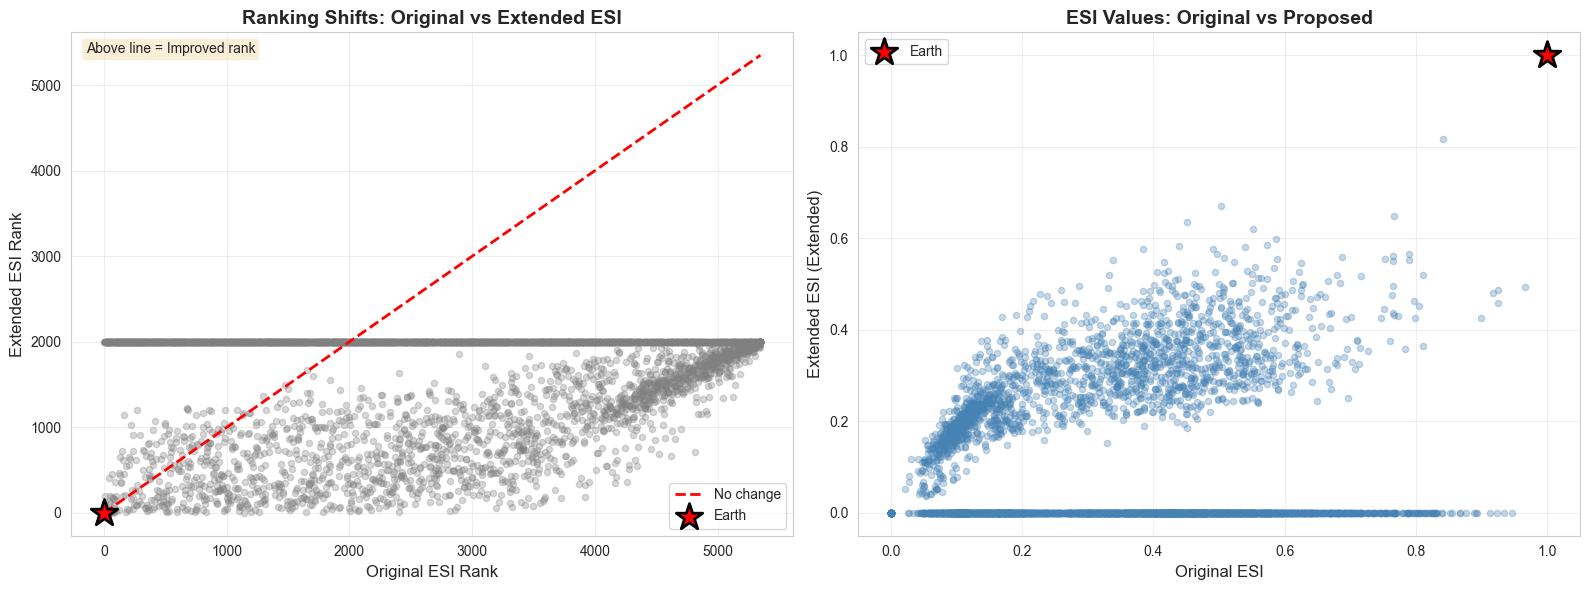

Saved: extended_esi_comparison.png


In [ ]:
# Viz 1: Ranking shift scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Rank comparison
axes[0].scatter(df_imputed['rank_esi'], df_imputed['rank_extended'], alpha=0.3, s=20, color='gray')
axes[0].plot([1, df_imputed['rank_esi'].max()], [1, df_imputed['rank_esi'].max()], 
             'r--', linewidth=2, label='No change')
axes[0].scatter(df_imputed.loc[earth_mask, 'rank_esi'], df_imputed.loc[earth_mask, 'rank_extended'],
               s=400, color='red', marker='*', edgecolors='black', linewidths=2, label='Earth', zorder=10)
axes[0].set_xlabel('Original ESI Rank', fontsize=12)
axes[0].set_ylabel('Extended ESI Rank', fontsize=12)
axes[0].set_title('Ranking Shifts: Original vs Extended ESI', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.98, 'Above line = Improved rank', transform=axes[0].transAxes,
            verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right: ESI comparison scatter
axes[1].scatter(df_imputed['esi'], df_imputed['extended_esi'], alpha=0.3, s=20, color='steelblue')
axes[1].scatter(df_imputed.loc[earth_mask, 'esi'], df_imputed.loc[earth_mask, 'extended_esi'],
               s=400, color='red', marker='*', edgecolors='black', linewidths=2, label='Earth', zorder=10)
axes[1].set_xlabel('Original ESI', fontsize=12)
axes[1].set_ylabel('Extended ESI (Extended)', fontsize=12)
axes[1].set_title('ESI Values: Original vs Proposed', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(reports_dir / "extended_esi_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: extended_esi_comparison.png")

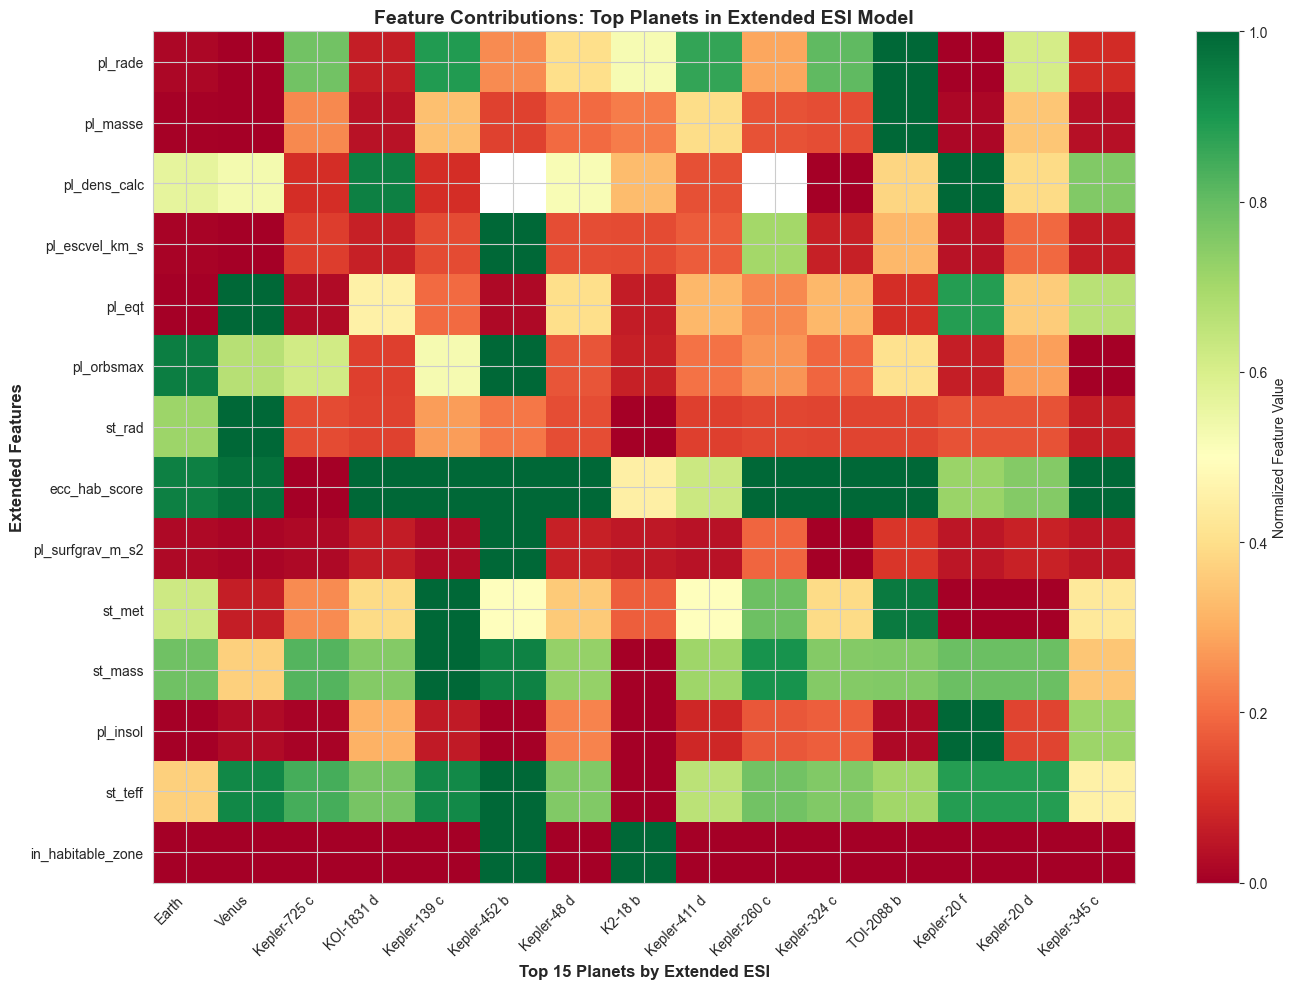

Saved: feature_contributions_heatmap.png


In [ ]:
# Viz 2: Feature contribution heatmap for top planets
top_15_proposed = df_imputed.nlargest(15, 'extended_esi')
feature_values = top_15_proposed[extended_results.extended_features].T

# Normalize for better visualization
feature_values_norm = (feature_values - feature_values.min(axis=1).values[:, None]) / \
                      (feature_values.max(axis=1).values[:, None] - feature_values.min(axis=1).values[:, None] + 1e-10)

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(feature_values_norm, aspect='auto', cmap='RdYlGn')

ax.set_xticks(range(len(top_15_proposed)))
ax.set_xticklabels(top_15_proposed['pl_name'].values, rotation=45, ha='right', fontsize=10)
ax.set_yticks(range(len(extended_results.extended_features)))
ax.set_yticklabels(extended_results.extended_features, fontsize=10)
ax.set_xlabel('Top 15 Planets by Extended ESI', fontsize=12, fontweight='bold')
ax.set_ylabel('Extended Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Contributions: Top Planets in Extended ESI Model', fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Normalized Feature Value')
plt.tight_layout()
plt.savefig(reports_dir / "feature_contributions_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: feature_contributions_heatmap.png")

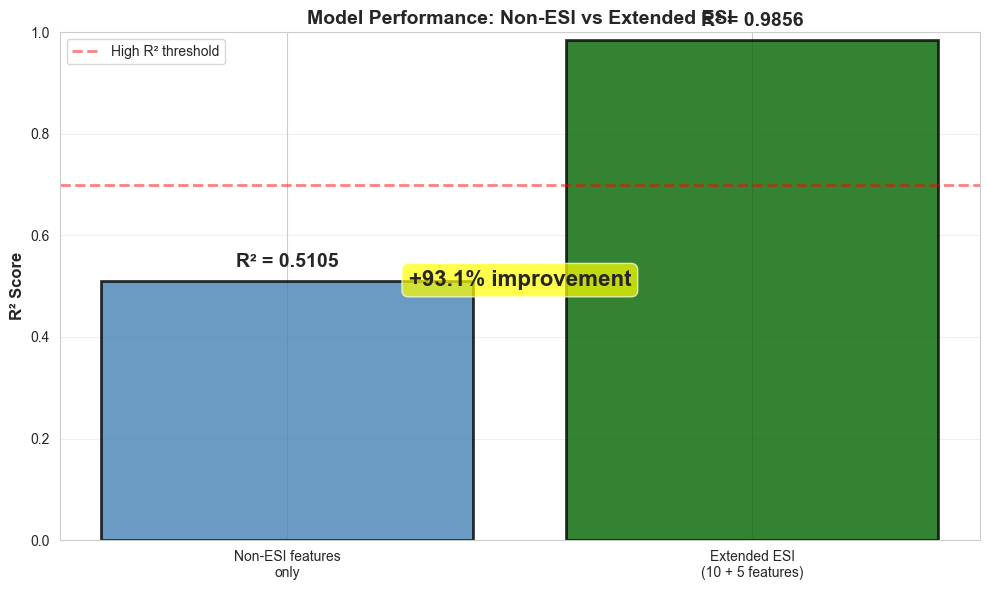

Saved: r2_comparison.png


In [18]:
# Viz 3: R² comparison bar chart
r2_values = [0.5105, extended_results.r2_score]
methods = ['Non-ESI features\nonly', f'Extended ESI\n({N_EXTENDED_FEATURES} + 5 features)']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, r2_values, color=['steelblue', 'darkgreen'], edgecolor='black', linewidth=2, alpha=0.8)

for i, (bar, val) in enumerate(zip(bars, r2_values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
           f'R² = {val:.4f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Non-ESI vs Extended ESI', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.7, color='red', linestyle='--', linewidth=2, alpha=0.5, label='High R² threshold')
ax.legend()

improvement = ((extended_results.r2_score - 0.5105) / 0.5105) * 100
ax.text(0.5, 0.5, f'+{improvement:.1f}% improvement', ha='center', fontsize=16,
       fontweight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
       transform=ax.transAxes)

plt.tight_layout()
plt.savefig(reports_dir / "r2_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: r2_comparison.png")

In [19]:
# Summary: Extended ESI key findings
print("\n" + "="*100)
print(" " * 30 + "EXTENDED ESI: KEY FINDINGS")
print("="*100)

print("\n1. R^2 IMPROVEMENT:")
print("\tNon-ESI features only:  R^2 = 0.5105 (51%)")
print(f"Extended ESI (15 feat): R^2 = {extended_results.r2_score:.4f} ({extended_results.r2_score*100:.1f}%)")
print(f"Improvement: +{((extended_results.r2_score - 0.5105)/0.5105)*100:.1f}%")

print("\n2. TOP 3 NON-ESI FEATURES IN EXTENDED MODEL:")
for idx, row in extended_results.importance_df.head(3).iterrows():
    if row['feature'] not in ESI_FEATURES:
        print(f"\t{idx+1}. {row['feature']:20s} SHAP: {row['mean_abs_shap']:.4f}")

print("\n3. RANKING CHANGES:")
print(f"\tTop 20 overlap:     {len(overlap)}/20 ({len(overlap)/20*100:.0f}%)")
print(f"\tNew candidates:     {len(new_candidates)}")
print(f"\tDropped:            {len(dropped)}")

print("\n4. CLUSTERING AGREEMENT:")
print(f"\tEarth's cluster vs Top 20 Proposed: {len(overlap_cluster_proposed)}/20 ({len(overlap_cluster_proposed)/20*100:.0f}%)")

print("\n" + "="*100)


                              EXTENDED ESI: KEY FINDINGS

1. R^2 IMPROVEMENT:
	Non-ESI features only:  R^2 = 0.5105 (51%)
Extended ESI (15 feat): R^2 = 0.9856 (98.6%)
Improvement: +93.1%

2. TOP 3 NON-ESI FEATURES IN EXTENDED MODEL:

3. RANKING CHANGES:
	Top 20 overlap:     2/20 (10%)
	New candidates:     18
	Dropped:            18

4. CLUSTERING AGREEMENT:
	Earth's cluster vs Top 20 Proposed: 5/20 (25%)



Generating SHAP summary plot...


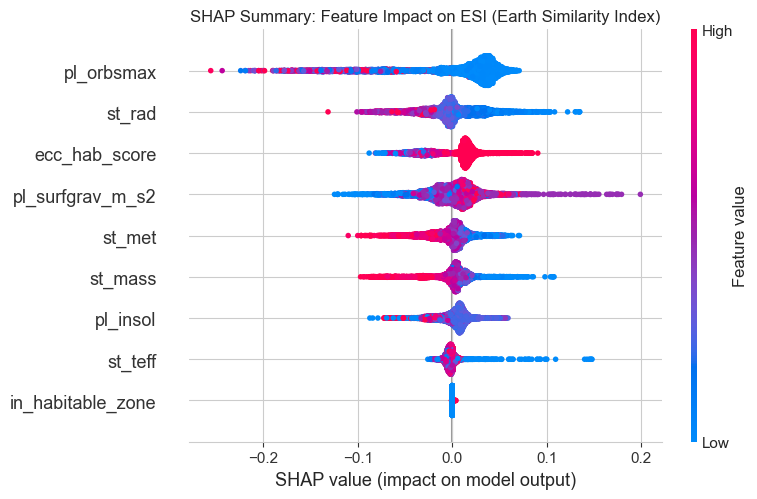


Top 20 planets by ESI (most Earth-like):
              pl_name      esi  pl_masse  pl_rade     pl_eqt  in_habitable_zone
                Earth 0.999936  1.000000 1.000000 255.000000                  0
         TRAPPIST-1 f 0.966019  1.039000 1.045000 217.700000                  0
             AU Mic d 0.946443  1.053000 1.020000 168.760873                  0
   Teegarden's Star b 0.934802  1.197844 1.050000 277.000000                  0
         TRAPPIST-1 e 0.925299  0.692000 0.920000 249.700000                  1
         TRAPPIST-1 c 0.924315  1.308000 1.097000 339.700000                  0
OGLE-2016-BLG-0007L b 0.923465  1.320000 1.090000 193.750425                  0
         TRAPPIST-1 g 0.917362  1.321000 1.129000 197.300000                  0
          LP 791-18 d 0.913450  0.900000 1.032000 395.500000                  0
         TRAPPIST-1 b 0.898853  1.374000 1.116000 397.600000                  0
             K2-384 b 0.892279  1.311310 1.076000 326.224508                  

In [21]:
# Use the same non-ESI feature columns that were used to compute SHAP
feature_cols = [
    col
    for col in feature_matrix.columns
    if col not in ESI_FEATURES + ["esi"]
]

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, feature_matrix[feature_cols], show=False)
plt.title("SHAP Summary: Feature Impact on ESI (Earth Similarity Index)")
plt.tight_layout()
plt.savefig(reports_dir / "shap_detailed.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nTop 20 planets by ESI (most Earth-like):")
top_esi = df_imputed.nlargest(20, "esi")[
    ["pl_name", "esi", "pl_masse", "pl_rade", "pl_eqt", "in_habitable_zone"]
]
print(top_esi.to_string(index=False))

## Research Question Answers

Using Extended ESI methodology to answer research questions from project proposal.

In [22]:
# RQ1: Earth's percentile position
key_features = ["pl_masse", "pl_rade", "pl_eqt", "pl_insol", "pl_escvel_km_s", "pl_dens_calc"]

earth_percentiles = {}
for feat in key_features:
    if feat in df_imputed.columns:
        data = df_imputed[feat].dropna()
        earth_val = df_imputed.loc[earth_mask, feat].values[0]
        if not np.isnan(earth_val):
            pct = (data < earth_val).sum() / len(data) * 100
            earth_percentiles[feat] = (earth_val, pct)

print("="*100)
print(" "*30 + "RESEARCH QUESTION 1")
print("How does Earth compare to other planets across key characteristics?")
print("="*100)
print("\nEarth's Percentile Position:")
for feat, (val, pct) in earth_percentiles.items():
    print(f"  {feat:20s}: {pct:5.1f}th percentile")
print("="*100)

                              RESEARCH QUESTION 1
How does Earth compare to other planets across key characteristics?

Earth's Percentile Position:
  pl_masse            :   3.5th percentile
  pl_rade             :   3.8th percentile
  pl_eqt              :   4.3th percentile
  pl_insol            :  12.3th percentile
  pl_escvel_km_s      :  15.0th percentile
  pl_dens_calc        :  75.0th percentile


In [27]:
# RQ2: Most similar planets using Extended ESI
earth_cluster_ext_df = df_imputed[df_imputed['kmeans_ext'] == earth_cluster_ext].copy()
earth_cluster_ext_df = earth_cluster_ext_df.sort_values('extended_esi', ascending=False)

print("\n" + "="*100)
print(" "*30 + "RESEARCH QUESTION 2")
print("Which planets are most similar to Earth (Extended ESI approach)?")
print("="*100)

print("\nMETHODOLOGY:")
print("\t1. Trained RF on non-ESI features → R² = 51% (ESI incomplete)")
print(f"\t2. Trained RF on ESI + {N_EXTENDED_FEATURES} non-ESI features → R² = {extended_results.r2_score:.1%}")
print("\t3. Used Extended model predictions as Extended ESI")
print("\t4. K-means clustering on 15 extended features")
print("\t5. Ranked by distance to Earth in extended feature space")

print("\nTOP 10 MOST SIMILAR PLANETS (Earth's cluster, Extended ESI):")
print("─"*120)
print(f"{'Rank':<6}{'Planet':<25}{'Dist':<10}{'Extended ESI':<13}{'Original ESI':<13}{'Orig Rank':<11}{'Ext Rank':<11}{'Rank Shift':<11}")
print("─"*120)

for idx, row in enumerate(earth_cluster_ext_df.head(10).itertuples(), 1):
    shift = int(row.rank_esi - row.rank_extended)
    shift_str = f"+{shift}" if shift > 0 else str(shift)
    print(
        f"{idx:<6}{row.pl_name:<25}{row.dist_earth_ext:<10.3f}"
        f"{row.extended_esi:<13.4f}{row.esi:<13.4f}"
        f"{int(row.rank_esi):<11}{int(row.rank_extended):<11}{shift_str:<11}"
    )

print("="*120)


                              RESEARCH QUESTION 2
Which planets are most similar to Earth (Extended ESI approach)?

METHODOLOGY:
	1. Trained RF on non-ESI features → R² = 51% (ESI incomplete)
	2. Trained RF on ESI + 10 non-ESI features → R² = 98.6%
	3. Used Extended model predictions as Extended ESI
	4. K-means clustering on 15 extended features
	5. Ranked by distance to Earth in extended feature space

TOP 10 MOST SIMILAR PLANETS (Earth's cluster, Extended ESI):
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Rank  Planet                   Dist      Extended ESI Original ESI Orig Rank  Ext Rank   Rank Shift 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1     Earth                    0.000     1.0000       0.9999       1          1          0          
2     Venus                    1.597     0.8177       0.8415       19         2        

In [ ]:
# H1: Popular planets hypothesis test
popular_planets_test = {
    "Kepler-452 b": "Earth's cousin",
    "TRAPPIST-1 e": "TRAPPIST HZ", 
    "Proxima Cen b": "Closest to Solar System",
    "Kepler-186 f": "First Earth-size in HZ",
    "Kepler-442 b": "High ESI"
}

print("\n" + "="*100)
print(" "*30 + "HYPOTHESIS TEST (H1)")
print("Do popular 'Earth-like' planets rank highest in Extended ESI?")
print("="*100)

print(f"\n{'Planet':<20}{'Description':<30}{'Original Rank':<14}{'Proposed Rank':<14}{'Shift':<10}")
print("─"*100)

popular_ranks_proposed = []
for pname, desc in popular_planets_test.items():
    matches = df_imputed[df_imputed["pl_name"].str.contains(pname.split()[0], case=False, na=False)]
    if len(matches) > 0:
        p = matches.iloc[0]
        rank_orig = int(p['rank_esi'])
        rank_prop = int(p['rank_extended'])
        shift = rank_orig - rank_prop
        shift_str = f"+{shift}" if shift > 0 else str(shift)
        popular_ranks_proposed.append(rank_prop)
        print(f"{pname:<20}{desc:<30}{rank_orig:<14}{rank_prop:<14}{shift_str:<10}")
    else:
        print(f"{pname:<20}{desc:<30}{'NOT FOUND':<14}{'NOT FOUND':<14}{'-':<10}")

in_top_20 = sum(1 for r in popular_ranks_proposed if r <= 20)
print("\n" + "─"*100)
print(f"RESULT: {in_top_20}/{len(popular_ranks_proposed)} popular planets in TOP 20 by Extended ESI")

if in_top_20 < len(popular_ranks_proposed) / 2:
    print("HYPOTHESIS SUPPORTED: Popular planets don't rank highest")
else:
    print("HYPOTHESIS NOT SUPPORTED: Popular planets do rank highly")
print("="*100)



                              HYPOTHESIS TEST (H1)
Do popular 'Earth-like' planets rank highest in Extended ESI?

Planet              Description                   Original Rank Proposed Rank Shift     
────────────────────────────────────────────────────────────────────────────────────────────────────
Kepler-452 b        Earth's cousin                738           6             +732      
TRAPPIST-1 e        TRAPPIST HZ                   6             123           -117      
Proxima Cen b       Closest to Solar System       265           1999          -1734     
Kepler-186 f        First Earth-size in HZ        235           1999          -1764     
Kepler-442 b        High ESI                      247           1999          -1752     

────────────────────────────────────────────────────────────────────────────────────────────────────
RESULT: 1/5 popular planets in TOP 20 by Extended ESI
HYPOTHESIS SUPPORTED: Popular planets don't rank highest


### Final Visualizations


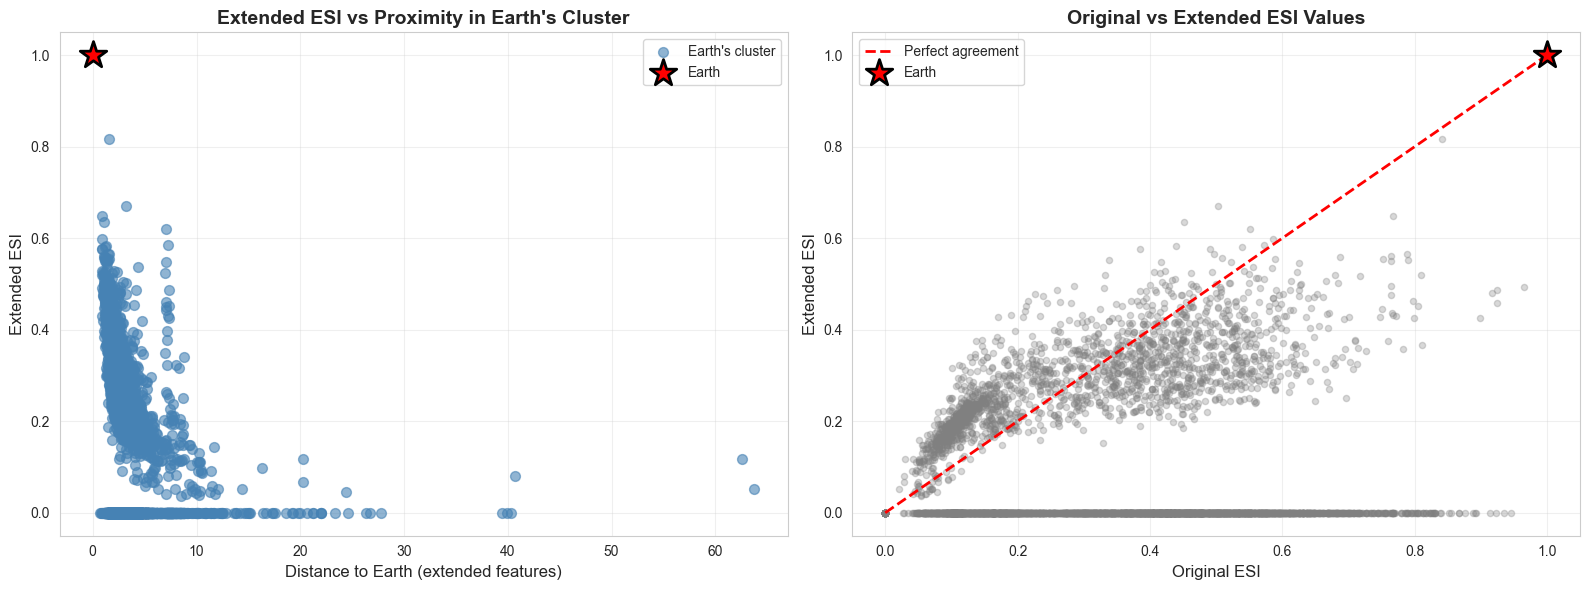

Saved: extended_esi_final.png


In [29]:
# Viz: Extended ESI vs Distance in Earth's cluster
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Extended ESI vs Distance
axes[0].scatter(earth_cluster_ext_df['dist_earth_ext'], earth_cluster_ext_df['extended_esi'],
               alpha=0.6, s=50, color='steelblue', label="Earth's cluster")
earth_data = earth_cluster_ext_df.iloc[0]
axes[0].scatter(earth_data['dist_earth_ext'], earth_data['extended_esi'],
               s=400, color='red', marker='*', edgecolors='black', linewidths=2, label='Earth', zorder=10)
axes[0].set_xlabel('Distance to Earth (extended features)', fontsize=12)
axes[0].set_ylabel('Extended ESI', fontsize=12)
axes[0].set_title('Extended ESI vs Proximity in Earth\'s Cluster', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Original vs Extended ESI
axes[1].scatter(df_imputed['esi'], df_imputed['extended_esi'], alpha=0.3, s=20, color='gray')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect agreement')
axes[1].scatter(df_imputed.loc[earth_mask, 'esi'], df_imputed.loc[earth_mask, 'extended_esi'],
               s=400, color='red', marker='*', edgecolors='black', linewidths=2, label='Earth', zorder=10)
axes[1].set_xlabel('Original ESI', fontsize=12)
axes[1].set_ylabel('Extended ESI', fontsize=12)
axes[1].set_title('Original vs Extended ESI Values', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(reports_dir / "extended_esi_final.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: extended_esi_final.png")